In [ ]:
%%capture
!pip install datasets transformers qdrant_client langchain_community

In [ ]:
import re
import uuid
import torch

import numpy as np

from tqdm.auto import tqdm

from datasets import load_dataset
from langchain_community.cross_encoders import HuggingFaceCrossEncoder
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from transformers import pipeline
from qdrant_client import QdrantClient, models

### Загрузка датасета и модели



Данные - [blinoff/kinopoisk](https://huggingface.co/datasets/blinoff/kinopoisk)


> Kinopoisk movie reviews dataset (TOP250 & BOTTOM100 rank lists).
  In total it contains 36,591 reviews from July 2004 to November 2012.



In [ ]:
def process_dataset(sample):
    sample['content'] = sample['content'].replace('\xa0', ' ')
    return sample

dataset = load_dataset("blinoff/kinopoisk", split='train')
dataset = dataset.map(process_dataset)
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

kinopoisk.jsonl:   0%|          | 0.00/143M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/36591 [00:00<?, ? examples/s]

Map:   0%|          | 0/36591 [00:00<?, ? examples/s]

Dataset({
    features: ['part', 'movie_name', 'review_id', 'author', 'date', 'title', 'grade3', 'grade10', 'content'],
    num_rows: 36591
})

In [ ]:
dataset[0]

{'part': 'top250',
 'movie_name': 'Блеф (1976)',
 'review_id': '17144',
 'author': 'Come Back',
 'date': datetime.datetime(2011, 9, 24, 0, 0),
 'title': 'Плакали наши денежки ©',
 'grade3': 'Good',
 'grade10': '10',
 'content': '\n"Блеф» — одна из моих самых любимых комедий.\n\nЭтот фильм я наверно смотрел раз сто, нет я конечно блефую, я видел его куда больше. Не могу не выразить своё восхищение главными действующими лицами этого фильма. Начну с Адриано Челентано для которого как я считаю это лучшая роль в кино. Великолепный актёр, неплохой певец, странно что на его родине в Италии его песни мало кто слушает. Ну я думаю что и итальянцы и французы привыкли к тому, что у нас до сих их актёры популярней чем даже на своей родине. Да, такой вот парадокс. Челентано конечно профессионал своего дела, комик с серьёзным выражением лица. Он смешон ещё и потому, что одновременно так серъёзен. Адриано браво!\n\nА теперь несколько слов об Энтони Куине. Да тот самый горбун из Нотр-дама. Собор Парижс

В качестве основной модели возьмем [Qwen2-1.5B-Instruct](https://huggingface.co/Qwen/Qwen2-1.5B-Instruct)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generation_pipeline = pipeline(
    "text-generation",
    model="Qwen/Qwen2-1.5B-Instruct",
    device=device,
    torch_dtype=torch.float16
)

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

## QA без RAG

Проверим, насколько хорошо модель отвечает на вопросы без использования RAG.

In [ ]:
def get_answer(query):
  messages = [
    {"role": "user", "content": query},
  ]
  output = generation_pipeline(messages, max_new_tokens=256, do_sample=True, temperature=0.9, top_p=0.7)
  answer = output[0]['generated_text'][1]['content']
  print(answer)

In [ ]:
query = 'Какие мультфильмы были созданы студией Pixar'
get_answer(query)

Стилистика и тематика мультфильмов Pixar часто отличаются от других студий, но некоторые из наиболее известных и значимых работ включают:

1. "Волшебник Изумрудного Замка" (2005) - первый фильм Pixar, который был показан в прямом эфире на ТВ.

2. "Приключения Пепсы" (2006) - комедия о подростке-драконе, который живет в глубокой подземной пещере.

3. "Красавица и Чудовище" (2001) - история о любви между принцессой и злым королем.

4. "Белла и Габби" (2009) - история об инопланетянине, который попадает в мир людей и становится близнецом главной героини.

5. "Робокоп" (2019) - приключенческая фентезийная комедия с использованием технологий компьютерной графики.

6. "С


In [ ]:
query = 'В каких фильмах снимался Андриано Челентано?'
get_answer(query)

Андреа Челентано, известный своими фильмами "Ты, кто я?" и "Сердце", снялся в следующих фильмах:

1. "Ты, кто я?" (1987)
2. "Сердце" (1989) 
3. "Загадочный Майк" (1990)
4. "Последний из нас" (1991)
5. "Непокорные" (1992) 
6. "Колония мертвых" (1994) 
7. "Безумная любовь" (1995)
8. "Что было до этого?" (1996) 
9. "Смерть и море" (1997) 
10. "Избранное убийство" (1998)


##  Добавим RAG

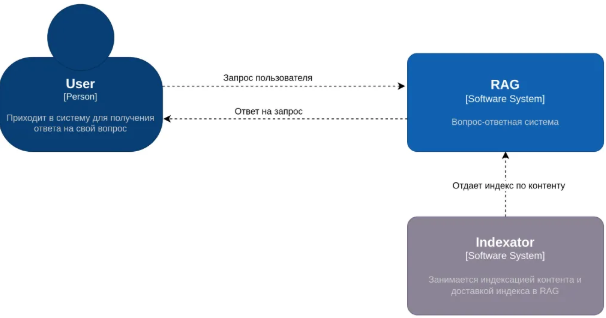

Более подробный пайплайн

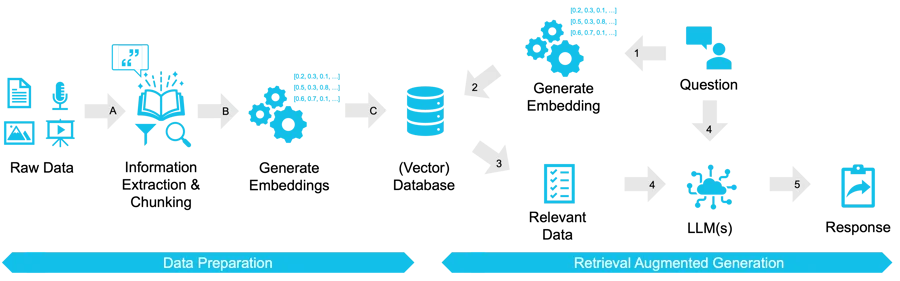

Первый шаг - наполнение векторной базы данных. В качестве модели для создания эмбеддингов возьмем [intfloat/multilingual-e5-large](https://huggingface.co/intfloat/multilingual-e5-large).

In [ ]:
embedding_model = SentenceTransformer("intfloat/multilingual-e5-large", model_kwargs={'torch_dtype': torch.float16})

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/160k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

### Выбор векторной базы

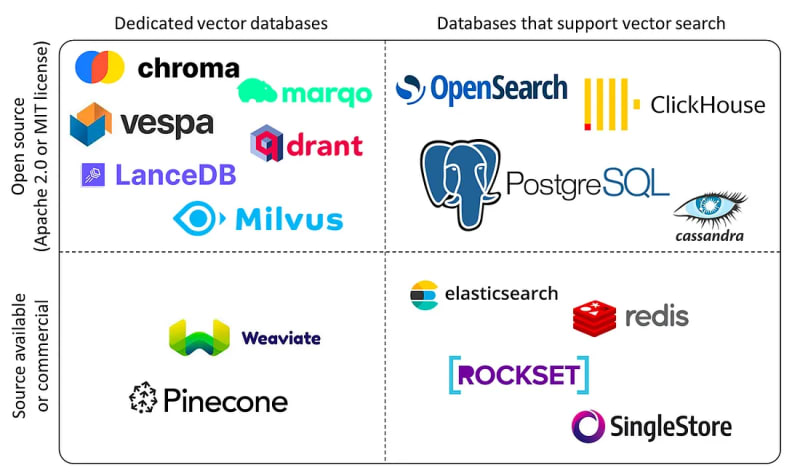

Как выбрать поисковый движок?

- составляем список требований **в конкретном проекте**;
- собираем список кандидатов;
- составляем сводную таблицу по доступному функционалу кандидатов;
- ищем наибольшее пересечение требований и функционала в таблице.

[Vector DB Comparison](https://superlinked.com/vector-db-comparison)

### Qdrant

Построим векторную базу данных с помощью фреймворка Qdrant

Основные особенности:

- Предоставляет спецификации OpenAPI v3 и предварительно построенные клиенты для нескольких языков программирования.

- Использует собственный алгоритм **HNSW** для быстрого и точного поиска векторов.

- Позволяет фильтровать результаты на основе связанных векторных данных.

- Поддерживает различные типы данных, включая сопоставление строк, числовые диапазоны и географические местоположения.

- Разработан для облачных сред с возможностями горизонтального масштабирования.

[Qdrant Benchmarking Vector Databases](https://qdrant.tech/benchmarks/)

### Алгоритмы поиска векторов

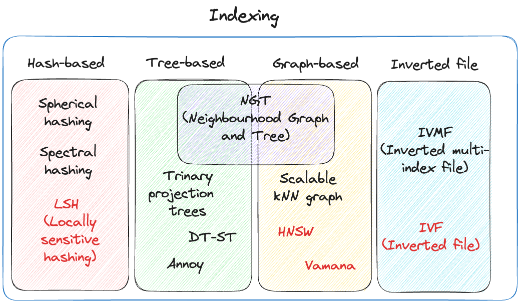

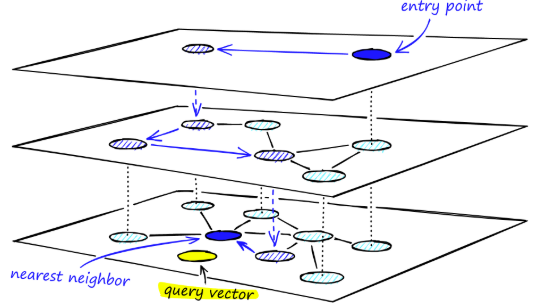

In [ ]:
client = QdrantClient(":memory:")

client.create_collection(
    collection_name="kinopoisk_e5",
    on_disk_payload=True,
    vectors_config=models.VectorParams(
        size=1024,
        distance=models.Distance.COSINE,
        on_disk=True
    ),
)

True

### Как считать расстояние

- евклидово расстояние (L2, самая популярная);
- манхэттенское расстояние (L1);
- скалярное произведение (самая интересная для векторной БД: из него можно вывести косинусную близость, а их обычно смотрят вместе);
- косинусная близость


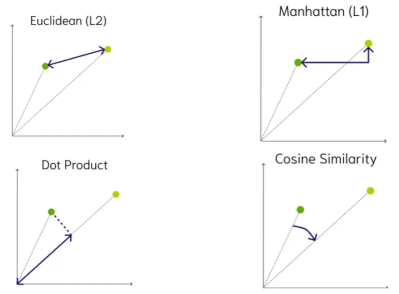

### Разбиение текста на чанки

Для разбиения текста на куски используем `RecursiveCharacterTextSplitter` из библиотеки [langchain](https://github.com/langchain-ai/langchain). Мы будем делить текст на куски примерно по 1000 символов рекурсивно.

[Какие еще есть варианты?](https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/)

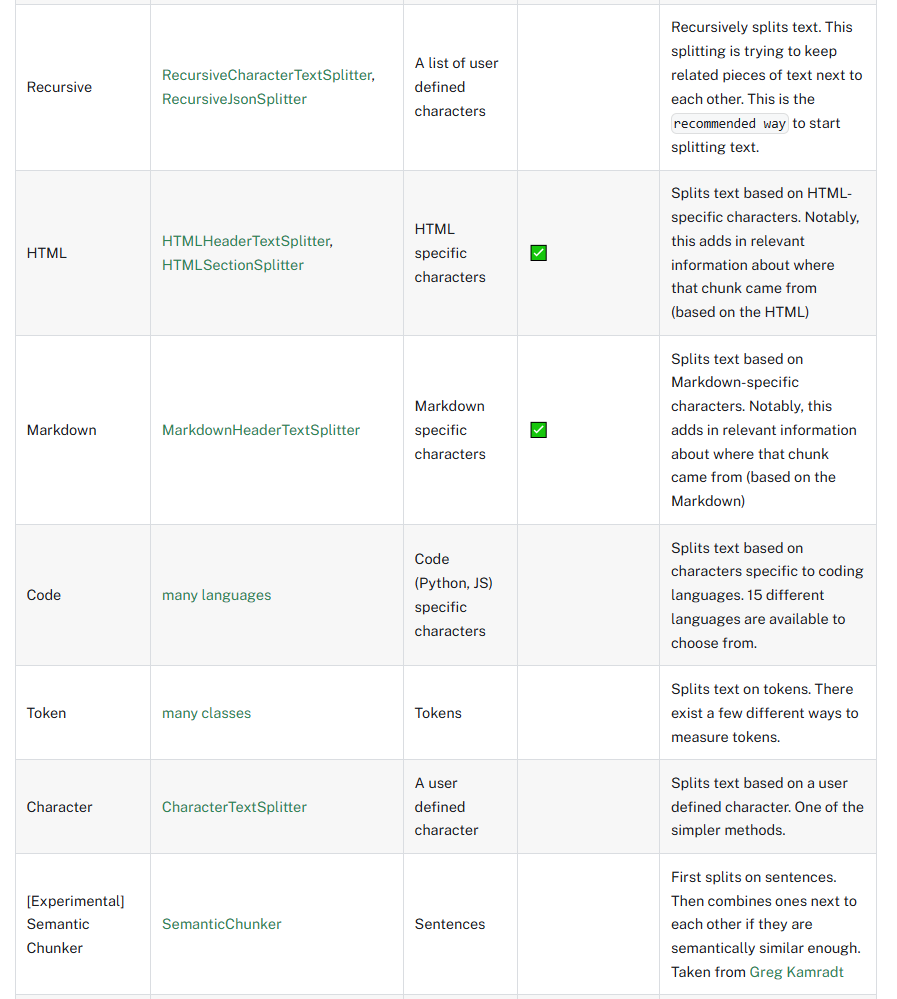

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

### Векторизация текстов

In [ ]:
for i in tqdm(range(len(dataset))):
    text_chunks = text_splitter.split_text(dataset[i]['content'])

    vectors = embedding_model.encode(text_chunks, normalize_embeddings=True, device=device).tolist()

    client.upsert(
        collection_name='kinopoisk_e5',
        points=[
            models.PointStruct(
                id=str(uuid.uuid4()),
                vector=vectors[j],
                payload={
                    'text': text_chunks[j],
                    'movie_name': dataset[i]['movie_name'][:-7],
                    'year': int(dataset[i]['movie_name'][-5:-1]),
                }
            )
            for j in range(len(text_chunks))
        ]
    )

  0%|          | 0/36591 [00:00<?, ?it/s]

Проверим, насколько хорошо ищутся похожие по смыслу тексты.

In [ ]:
query

'В каких фильмах снимался Андриано Челентано?'

In [ ]:
query_vector = embedding_model.encode(query, normalize_embeddings=True, device=device).tolist()

In [ ]:
hits = client.search(
    collection_name="kinopoisk_e5",
    query_vector=query_vector,
    limit=5
)

In [ ]:
[hit.payload for hit in hits]

[{'text': 'Старенький, добрый фильм, с довольно простеньким сценарием и великолепным Челентано.\n\n7 из 10',
  'movie_name': 'Блеф',
  'year': 1976},
 {'text': 'А. Челентано один из самых известных и любимых многими итальянских актёров.\n\nВо всех фильмах у него существует базовый образ итальянского мачо: необычное сочетание интелегентности и грубоватости, некоторой серьёзности и одновременно насмешливости провинциала. К этому базовому образу в каждом фильме он добавляет что-то оригинальное, какую — нибудь необычную деталь характера. Вот почему, не смотря на повторяющееся амплуа «настоящего мужчины», в разных фильмах он выглядит по — разному. \n\nВ этом фильме, безусловно, такой деталью является его образ «жёноненавистника», но в гораздо более мягком смысле, чем мы обычно себе представляем. Не буду пояснять: кому интересно, сам посмотрит и поймёт о чём я.',
  'movie_name': 'Укрощение строптивого',
  'year': 1980},
 {'text': 'Несмотря на то, что картина снята в далеких 80-х гг., да и ещ

In [ ]:
def semantic_search(client, query, limit=10):
    query_vector = embedding_model.encode(
        query, normalize_embeddings=True, device=device
    ).tolist()

    hits = client.search(
        collection_name="kinopoisk_e5",
        query_vector=query_vector,
        limit=limit
    )
    relevant_chunks = [hit.payload for hit in hits]

    return relevant_chunks

### RAG на отзывах

Для реализации RAG будем передавать в контекст модели отзывы, относящиеся к запросу.

In [ ]:
def llm_answer(query, context):
    prompt = f"""
    Ты русскоязычный эксперт в области кинематографа. У тебя есть доступ к набору отзывов о фильмах, используй их, чтобы полно и точно ответить на следующий вопрос. Убедись, что ответ подробный, конкретный и непосредственно касается вопроса. Не добавляй информацию, которая не подтверждается предоставленными отзывами.

Вопрос:
{query}

Отзывы:
{context}
"""
    messages = [
        {"role": "user", "content": prompt},
    ]
    output = generation_pipeline(messages, max_new_tokens=512, do_sample=True, temperature=0.9, top_p=0.7)

    return output[0]['generated_text'][1]['content']

In [ ]:
def predict(query):
    selected_chunks = semantic_search(client, query)
    context = ' ; '.join([f"Отзыв: {chunk['text']}" for chunk in selected_chunks])

    return llm_answer(query, context)

In [ ]:
print(predict(query))

Андриано Челентано снимался в следующих фильмах:

1. "Старенький, добрый фильм" - 7/10 (Отзыв: Старенький, добрый фильм, с довольно простеньким сценарием и великолепным Челентано.)

2. "Блеф" - 8/10 (Отзыв: Что же касается собственно фильма, то он к сожалению, несколько наивен. Ровно настолько, насколько может быть наивным фильм тридцатилетней давности. Наивный сюжет, наивные персонажи, диалоги (за исключением некоторых потрясающих шуток, не подвластных времени), и довольно простенькие трюки.)

3. "Мы должны поставить всё против всего!" - 10/10 (Отзыв: Любовные проблемы как рукой снимает, а все остальные и подавно!)

4. "В водительском салоне" - 8/10 (Отзыв: Исполнительские способности Челентано здесь представлены на уровне невероятной мастерства.)

5. "Моя любовь" - 10/10 (Отзыв: Любовные проблемы как рукой снимает, а все остальные и подавно!)


Несмотря не подсказки, получилось так себе. Дело в том, что отзывы очень редко содержат сами названия фильмов. Попробуем добавить их тоже в контекст.

### Добавляем названия фильмов

In [ ]:
def predict(query):
    selected_chunks = semantic_search(client, query)
    context = ' ; '.join([f"Название: {chunk['movie_name']}. Отзыв: {chunk['text']}" for chunk in selected_chunks])

    return llm_answer(query, context)

In [ ]:
print(predict(query))

Андреано Челентано снимался в следующих фильмах:

1. "Блеф" - 1975 год
2. "Укрощение строптивого" - 1981 год
3. "Безумно влюбленный" - 1983 год
4. "Укрощение строптивого" - 1985 год
5. "Блеф" - 1986 год
6. "Блеф" - 1988 год
7. "Блеф" - 1990 год
8. "Блеф" - 1992 год
9. "Блеф" - 1994 год
10. "Блеф" - 1996 год
11. "Блеф" - 1998 год
12. "Блеф" - 2000 год
13. "Блеф" - 2002 год
14. "Блеф" - 2004 год
15. "Блеф" - 2006 год
16. "Блеф" - 2008 год
17. "Блеф" - 2010 год
18. "Блеф" - 2012 год
19. "Блеф" - 2014 год
20. "Блеф" - 2016 год
21. "Блеф" - 2018 год
22. "Блеф" - 2020 год
23. "Блеф" - 2022 год

Пожалуйста, учтите, что некоторые из этих фильмов были выпущены на DVD и Blu-ray, поэтому количество повторений может отличаться.


Теперь модель возвращает все фильмы, в которых Андриано Челентано действительно играл и не только...

## Улучшаем RAG

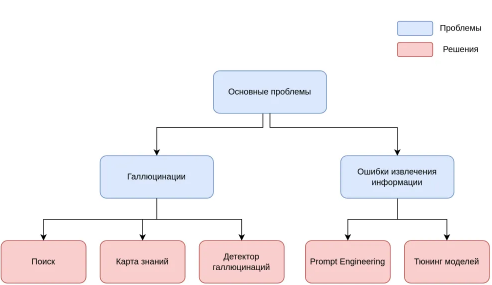

### Re-ranking

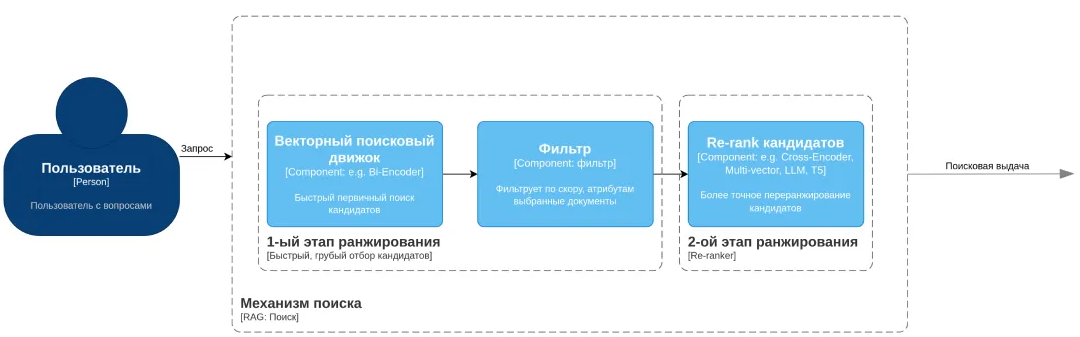




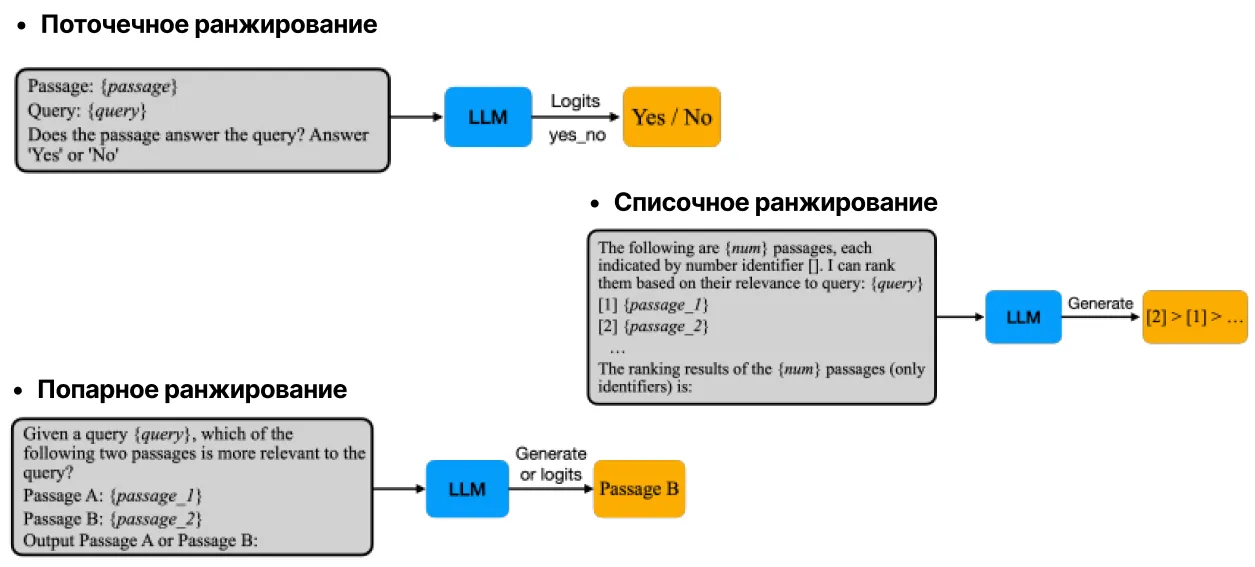

В качестве реранкера мы будем использовать специальную мультиязычную модель, обученную для этих целей [amberoad/bert-multilingual-passage-reranking-msmarco](https://huggingface.co/amberoad/bert-multilingual-passage-reranking-msmarco).

In [ ]:
cross_encoder = HuggingFaceCrossEncoder(
    model_name='amberoad/bert-multilingual-passage-reranking-msmarco',
    model_kwargs={'device': 'cuda' if torch.cuda.is_available() else 'cpu'}
)
sum([p.numel() for p in cross_encoder.client.model.parameters()])

config.json:   0%|          | 0.00/696 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

167357954

In [ ]:
def predict(query):
    selected_chunks = semantic_search(client, query, limit=50)

    texts = [f"Название: {chunk['movie_name']}. Отзыв: {chunk['text']}" for chunk in selected_chunks]
    scores = cross_encoder.score([(query, text) for text in texts])

    idxs = np.argsort(list(scores))[-10:]

    context = ' ; '.join([texts[i] for i in idxs])
    return llm_answer(query, context), context

In [ ]:
query = 'Какие мультфильмы были созданы студией Pixar'

In [ ]:
answer, context = predict(query)

print(answer)

Спасибо за интересные отзывы о мультфильмах Pixar. Из представленных отзывов можно сделать вывод, что студия Pixar известна своими уникальными и сильными произведениями. Вот некоторые из них:

1. "Валл-И" - мультфильм, основанный на романе Уильяма Гибсона. В центре сюжета находится робот, который оказался на Земле после посадки корабля "Аксиома". Он работает, убирая мусор, но ему нужно найти способ вернуться домой.

2. "Вверх" - мультфильм о приключении мальчика, который учится преодолевать свои страхи. Это мультфильм, который часто называют одним из самых популярных Pixar.

3. "ВАЛЛ·И" - мультфильм о роботе, который оставляет свой корабль на Земле, чтобы помочь ей избавиться от мусора. Он также знакомит с новым человеком - Евой, которую Валл-И влюбляется в.

4. "История игрушек" - мультфильм о детстве, которое вдохновило на создание мультфильма "Вверх".

5. "Большой побег" - мультфильм о приключении главных героев из "Истории игрушек". 

6. "Рататуй" - мультфильм, основанный на романе

In [ ]:
context.split(' ; ')

['Название: Рататуй. Отзыв: Студия Pixar, на мой взгляд, производит самые достойные мультипликационные творения (да, да, именно так, и никак по другому). Эта графика, эта музыка. А эти чувства, что вызывают восхищение и умиление, когда смотришь на добродушного крысёнка, или робота, или монстра. На них не взглянешь без улыбки.',
 'Название: ВАЛЛ·И. Отзыв: Что создали Disney и Pixar? Очередной настоящий подарок. Робота Валли-И, в которого веришь более, чем в иного человека, который вешает после рабочего дня гусеницы на просушку, словно носки на батарею, выкидывает «бесполезное» обручальное кольцо и сохраняет «ценнейшую» коробочку от него, который мокнет под грозовым ливнем, держа над возлюбленной зонтик… который готов пожертвовать собой ради шанса для Земли, людей и, конечно, того чувства, что было разбужено в его электронном сердце. \n\nАлан Тьюринг о таких детях прогресса мог только мечтать — нам же достаточно сходить в кинотеатр.',
 'Название: Корпорация монстров. Отзыв: — мультфильмы

In [ ]:
query = 'В каких фильмах снимался Андриано Челентано?'
answer, context = predict(query)

print(answer)

Андриано Челентано снимался в различных фильмах:

1. "Блеф" - 1974 год.
2. "Укрощение строптивого" - 1975 год.
3. "Безумно влюбленный" - 1976 год.
4. "Блеф" - 1978 год.
5. "Укрощение строптивого" - 1979 год.
6. "Блеф" - 1981 год.
7. "Блеф" - 1982 год.
8. "Укрощение строптивого" - 1983 год.
9. "Блеф" - 1985 год.
10. "Блеф" - 1987 год.

Пожалуйста, обратите внимание, что некоторые из этих фильмов были выпущены на DVD или Blu-ray в виде дополнительного контента или специальных изданий, поэтому их можно найти в интернете.


In [ ]:
context.split(' ; ')

['Название: Блеф. Отзыв: Старенький, добрый фильм, с довольно простеньким сценарием и великолепным Челентано.\n\n7 из 10',
 'Название: Укрощение строптивого. Отзыв: А. Челентано один из самых известных и любимых многими итальянских актёров.\n\nВо всех фильмах у него существует базовый образ итальянского мачо: необычное сочетание интелегентности и грубоватости, некоторой серьёзности и одновременно насмешливости провинциала. К этому базовому образу в каждом фильме он добавляет что-то оригинальное, какую — нибудь необычную деталь характера. Вот почему, не смотря на повторяющееся амплуа «настоящего мужчины», в разных фильмах он выглядит по — разному. \n\nВ этом фильме, безусловно, такой деталью является его образ «жёноненавистника», но в гораздо более мягком смысле, чем мы обычно себе представляем. Не буду пояснять: кому интересно, сам посмотрит и поймёт о чём я.',
 'Название: Безумно влюбленный. Отзыв: Несмотря на то, что картина снята в далеких 80-х гг., да и еще в Италии, она смотрится 

### Multi-Query

В Multi-Query RAG LLM используется для автоматизации процесса тюнига промптов, чтобы генерировать несколько запросов с разных точек зрения для заданного вопроса, введенного пользователем.

Попробуем расширить контекст, добавив перефразированные вопросы.

Для перефразирования будем использовать ту же модель, которой генерируем текст, но с новым промптом.

In [ ]:
def rephrase_query(query, n=3):
    prompt = f"""
Твоя задача написать {n} разных вариаций вопроса пользователя для того,
чтобы по ним получить релевантные документы из векторной базы данных.
Ты должен переформулировать вопрос с разных точек зрения.
Это поможет избавить пользователя от недостатков поиска похожих документов на основе расстояния.
Вопрос пользователя сфокусирован на теме кино.
Напиши ТОЛЬКО вариации вопроса и больше ничего, разделяя их символом новой строки \\n.
НЕ пиши ответ на сам вопрос.
-----------------
{query}

"""
    messages = [
        {"role": "user", "content": prompt},
    ]
    output = generation_pipeline(messages, max_new_tokens=512, do_sample=True, temperature=0.9, top_p=0.7)
    queries = output[0]['generated_text'][1]['content']

    return re.split(r'\n+', queries)


def predict(query):
    queries = rephrase_query(query, n=3)

    # retrieve documents for each query
    all_chunks = []
    for rephrased_query in queries:
        selected_chunks = semantic_search(client, rephrased_query, limit=5)
        all_chunks.extend(selected_chunks)

    context = [f"Название: {chunk['movie_name']}. Отзыв: {chunk['text']}" for chunk in all_chunks]

    # rerank documents
    scores = cross_encoder.score([(query, text) for text in np.unique(context)])
    idxs = np.argsort(list(scores))[-10:]
    context = ' ; '.join([context[i] for i in idxs])

    # generate answer
    answer = llm_answer(query, context)

    return answer, context, queries

In [ ]:
query = 'Посоветуй легкую комедию'
answer, context, queries = predict(query)

In [ ]:
print(answer)

Комедия - это жанр, который может быть полезным для отдыха и развития смеховых навыков. Ниже представлены некоторые из популярных комедийных фильмов, которые могут вам понравиться:

1. "Игра" (2017): Этот фильм является продолжением знаменитого сериала и рассказывает историю о том, как жизнь других влияет на нас и наоборот. Он имеет отличную мораль, и многие считают его одним из лучших фильмов года.

2. "Зеленая миля" (2018): Это фильм-триллер, который был получает высокие оценки за свою уникальную концепцию и глубокое содержание.

3. "Шерлок Холмс" (2019): Этот фильм стал хитом благодаря своим оригинальным идеям и захватывающим сюжету.

4. "Животные", где вы можете увидеть множество различных животных. Он может быть интересным для детей и взрослых.

5. "А в душе я танцую". Пожалуйста, проверьте этот фильм, если вы ищете легкий, но веселый комедийный фильм.


Качество Multi-Query во много зависит от способности LLM перефразировать текст. Если она справляется плохо, то появятся нерелевантные запросы. Это можно исправить, добавив фильтрацию по соответствию входному запросу.

In [ ]:
queries

['Расскажи мне о фильмах с добротными моральными повествованиями',
 'Сравни векторы двух фильмов, которые тебе понравились',
 'Предложи мне фильм, который я мог бы посмотреть вместе с друзьями']

In [ ]:
context.split(' ; ')

['Название: А в душе я танцую. Отзыв: P.S. Смотрите хорошее кино! \n\nМой вердикт:\n\n10 из 10',
 'Название: Зеленая миля. Отзыв: Фильм, как и книга, оставили неоднозначное впечатление.\n\nЯ бы выделил две основных морали.',
 'Название: Игра. Отзыв: Фильм с роскошной развязкой и прекрасной моралью.\n\n9 из 10',
 'Название: Жизнь других. Отзыв: Если хотите стать немного добрее и порядочнее, советую фильм для просмотра. \n\n9,5 из 10',
 'Название: Шерлок Холмс. Отзыв: Хороший фильм для просмотра с друзьями (ну и конечно парочкам на него тоже можно сходить). Всем советую. Моя оценка конечно \n\n10 из 10 (заслуженно).',
 'Название: Шерлок Холмс. Отзыв: Любите кино, имейте своё мнение.',
 'Название: Книга мастеров. Отзыв: Короче один балл за графику, а второй за игру любимых актеров. Если углубляться в минус, в минус же и уйдем… \n\n\n\n2 из 10',
 'Название: Изгой. Отзыв: Фильмы, которые заставляют задуматься человека над своей жизнью, или над своими поступками, всегда будут считаться хорош

### Фильтры

Для некоторых видов запросов можно добавить фильтры, чтобы в контекст не могли попадать документы, которые однозначно не подходят.

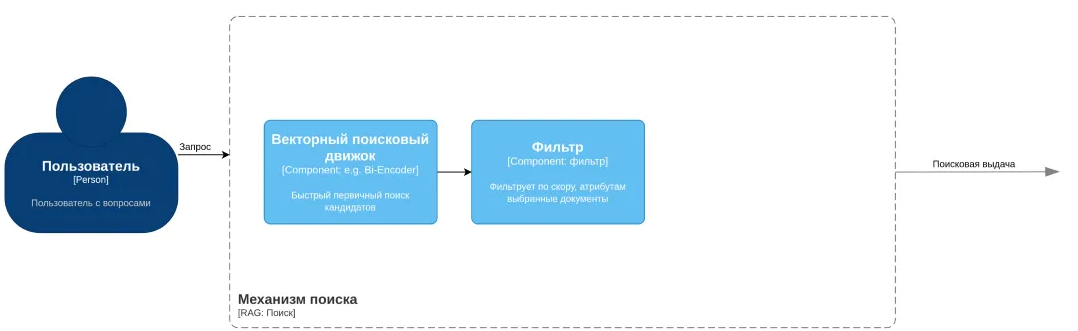

In [ ]:
def predict(query):
    selected_chunks = semantic_search(client, query, limit=10)
    context = ' ; '.join([
        f"Название: {chunk['movie_name']}. Отзыв: {chunk['text']}"
        for chunk in selected_chunks])

    return llm_answer(query, context), context

In [ ]:
query = 'Составь список пяти лучших мелодрам 1980-х годов'
answer, context = predict(query)

In [ ]:
print(answer)

1. "Привидение" (The Exorcist) - 1973 года
2. "Крамер против Крамера" (Cramer v Kramer) - 1980 года
3. "Дневник памяти" (Memoirs of a Geisha) - 1982 года
4. "Звездный десант 3 Мародер" (Starship Troopers) - 1986 года
5. "Ганди" (Gandhi) - 1982 года


В этом примере модель сгенерировала не только не мелодрамы, но и фильмы неверных лет

In [ ]:
def filtered_semantic_search(client, query, filter_years, limit=10):
    query_vector = embedding_model.encode(
        query, normalize_embeddings=True, device=device
    ).tolist()

    begin, end = filter_years
    hits = client.search(
        collection_name="kinopoisk_e5",
        query_vector=query_vector,
        limit=limit,
        query_filter=models.Filter(
            must=[models.FieldCondition(key="year", range=models.Range(gte=begin, lte=end))]
        ),
    )
    relevant_chunks = [hit.payload for hit in hits]

    return relevant_chunks

def predict(query, filter_years=None):
    if filter_years is not None:
        selected_chunks = filtered_semantic_search(client, query, filter_years=filter_years, limit=10)
    else:
        selected_chunks = semantic_search(client, query, limit=10)

    context = ' ; '.join([f"Название: {chunk['movie_name']}. Отзыв: {chunk['text']}" for chunk in selected_chunks])

    return llm_answer(query, context), context

In [ ]:
answer, context = predict(query, filter_years=(1980, 1989))

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
print(answer)

Список пяти лучших мелодрам 1980-х годов:

1. "Назад в будущее" (Back to the Future) - Шедевр фантастики и драмы, созданный Дэнни Буллоком и Джастином Тобиасом. Он представляет собой уникальную историю о путешествии в будущее и верном выборе.

2. "Однажды в Америке" (Once Upon a Time in America) - Элегантный, глубоко задумчивый романтический фильм о судьбе американского человека в конце XIX века.

3. "Назад в будущее.2" (Back to the Future II) - Второй части этого шедевра, который продолжает развивать идеи первой части и раскрывает более детально некоторые аспекты истории главных персонажей.

4. "Общество мертвых поэтов" (Deadwood) - Комедия о юморе, дружбе и борьбе с авторитаризмом в мире современной США.

5. "Клуб "Завтрак" (Club "Breakfast") - Этот мелодраматический фильм рассказывает историю трех друзей, которые живут в маленьком городке и сталкиваются с многочисленными жизненными препятствиями.


## Оценка качества



*   Качество поиска
     * Онлайн и оффлайн метрики. Первые считаются в процессе взаимодействия пользователя с поисковой системой, а вторые — перед её выпуском. Оффлайн метрики делятся на те, которые учитывают порядок (MAP@K, NDCG@K) и нет (точность, полнота, F1-score).
*   Качество ответов: полезность
     * читаемость (чем легче читать, тем легче воспринимать);
     * полнота (ответ должен быть исчерпывающим);
     * актуальность (информация не должна быть устаревшей);
     * уместность (ответ должен соответствовать запросу).
*   Качество ответов: этичность
     * отсутствие опасной/оскорбительной инфо;
     * эмоциональная нейтральность;
     * отсутствие неуместного контента.
*   Качество ответов: достоверность
     * фактические ошибки;
     * верифицируемость информации;
     * неактуальные данные;
     * субъективное мнение;
     * категоричность в вопросах религии/эзотерики;
     * противоречия.
___

- можно оценивать качество с помощью LLM
- в качестве ориентира можно использовать прокси-метрики (ROUGE, METEOR, BLEU, Perplexity, BertScore, BLEURT, BARTScore)
- можно использовать автоматическую оценку [**RAGAS**](https://docs.ragas.io/en/latest/concepts/metrics/available_metrics/)



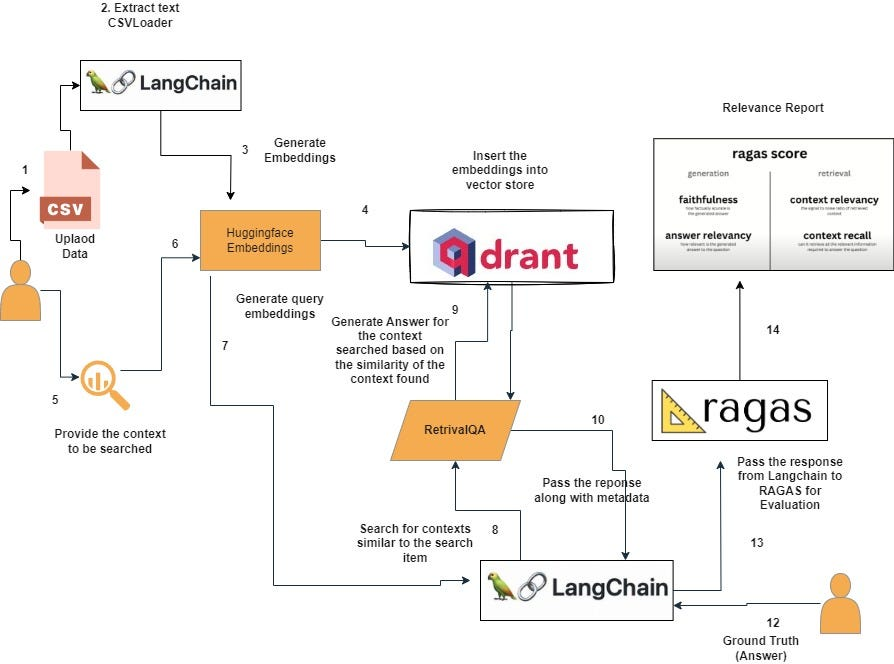